In [6]:
 # Some general imports
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
plt.style.use('fivethirtyeight')
# Custom code (see ngram_lm.py and utils.py)
from ngram_lm import ngrams, UnsmoothedLM, characters_from_files, words_from_files
import utils

# How to fit the model

- Compute ngrams
- Count number of times each ngram appears in front of each vocabulary item
- Normalize into probabilities

In [6]:
# Uncomment this block to get some real shakespeare data
#!wget http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
with open('shakespeare_input.txt', 'r') as f:
    corpus = [c for sent in f for c in sent]
    
print(''.join(corpus[:10]))

First Citi


## Compute n-grams

In [11]:
# `ngram`: function defined in ngram_lm.py that computes ngrams over input sequences
for i in ngrams(corpus[:10], 3):
    print(i)

('<pad>', '<pad>', 'F')
('<pad>', 'F', 'i')
('F', 'i', 'r')
('i', 'r', 's')
('r', 's', 't')
('s', 't', ' ')
('t', ' ', 'C')
(' ', 'C', 'i')
('C', 'i', 't')
('i', 't', 'i')


## Count prefix/target co-occurrences and normalize into probabilities

In [7]:
model = defaultdict(Counter)

# count prefix/target co-occurrences
for ngram in ngrams(corpus, 5):
    # use first n-1 characters as prefix, last character as target
    *prefix, target = ngram
    model[tuple(prefix)][target] += 1 # accumulate counts
    
# normalize into probability distribution
for prefix, counter in model.items():
    total = sum(counter.values())
    model[prefix] = [(target, counts/total) for target, counts in counter.items()]

# Sampling from the model

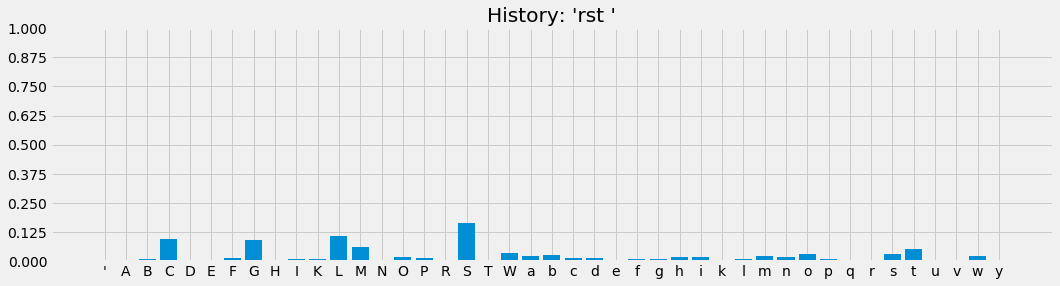

In [8]:
# Visualize output distribution by querying the model and displaying output probability distribution

# random ngram from the corpus
prefix = 'rst ' 
targets, probs = zip(*model[tuple(prefix)])
# function from utils.py to plot an output distribution
ax = utils.plot_output(targets, probs, prefix)

# RNN-based Language Model

- Exploit RNN capability to model forward information flow to condition the output probability on theoretically all previous steps
- While ngram model is limited in scope by the "markov" assumption that any character is only conditioned by the previous n characters, an RNN-based model is able to capture much longer dependencies

In [7]:
# To run this cell you'll need to make sure you have it
#   1. clone or download the package from "https://github.com/emanjavacas/hierarchical-lm"
#   2. put it on your python path
#       import sys; sys.path.append("/path/to/hierarchical-lm/")
path = '/home/manjavacas/code/python/hierarchical-lm/'
import sys
if path not in sys.path:
    sys.path.append(path)

from hierarchical_lm import loader
wordlm, word_encoder = loader.model_loader('models/RNNLanguageModel.2019-03-26+17:02:48')
charlm, char_encoder = loader.model_loader('models/CharLanguageModel.2019-03-26+10:56:35')

In [34]:
hidden = None
for _ in range(5):
    (sample, _), score, hidden, _ = wordlm.sample(word_encoder, hidden=hidden, top_p=0.9, avoid_unk=True)
    print(sample[0])

To which his honour after more than best Was on a brave axe .
Every hand Shall he return in with such captives brows .
An honourable justice , You know him .
by the Lord , I think thou dost not well and thou .
So thou wilt find him till my words be proud , So art thou with thy wealth and crown thy wrongs .


## Visualizing the generation process

In [8]:
prompt = "Th"

Sampled symbol: 'o'


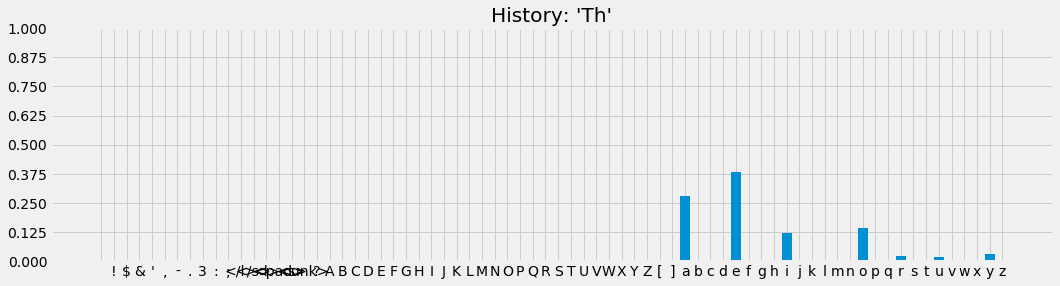

In [9]:
targets, probs = charlm.get_next_probability(char_encoder, [prompt.split() + [' ' if prompt.endswith(' ') else '']])
utils.plot_output(targets, probs[0], prompt)
sampled = targets[torch.multinomial(torch.tensor(probs), 1).item()]
prompt += sampled
print("Sampled symbol: '{}'".format(sampled))

Sampled symbol: 'u'


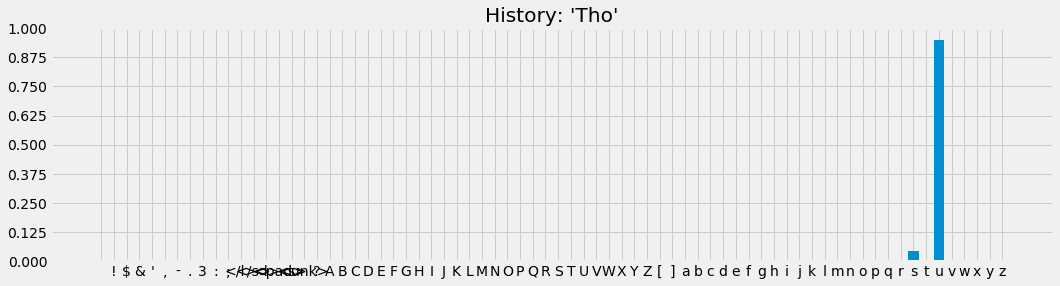

In [10]:
targets, probs = charlm.get_next_probability(char_encoder, [prompt.split() + [' ' if prompt.endswith(' ') else '']])
utils.plot_output(targets, probs[0], prompt)
sampled = targets[torch.multinomial(torch.tensor(probs), 1).item()]
prompt += sampled
print("Sampled symbol: '{}'".format(sampled))

Sampled symbol: ' '


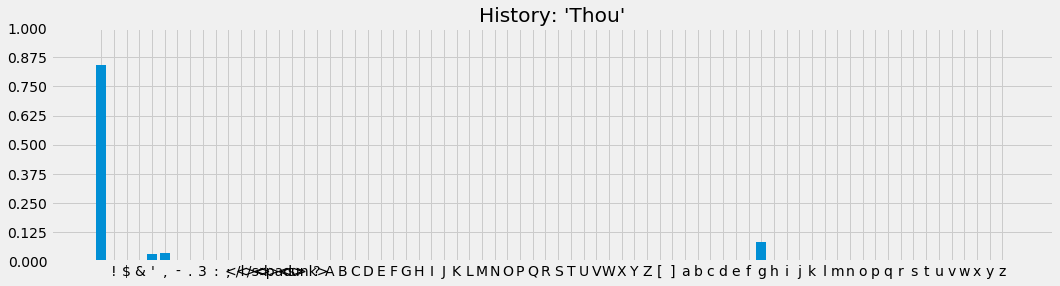

In [11]:
targets, probs = charlm.get_next_probability(char_encoder, [prompt.split() + [' ' if prompt.endswith(' ') else '']])
utils.plot_output(targets, probs[0], prompt)
sampled = targets[torch.multinomial(torch.tensor(probs), 1).item()]
prompt += sampled
print("Sampled symbol: '{}'".format(sampled))

Sampled symbol: 'g'


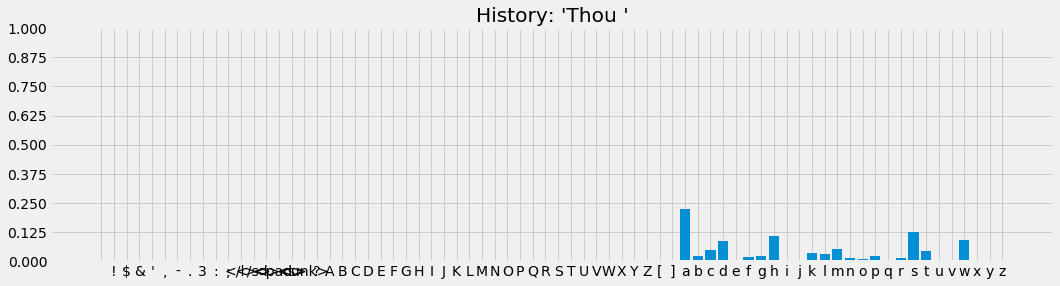

In [12]:
targets, probs = charlm.get_next_probability(char_encoder, [prompt.split() + [' ' if prompt.endswith(' ') else '']])
utils.plot_output(targets, probs[0], prompt)
sampled = targets[torch.multinomial(torch.tensor(probs), 1).item()]
prompt += sampled
print("Sampled symbol: '{}'".format(sampled))

Sampled symbol: 'r'


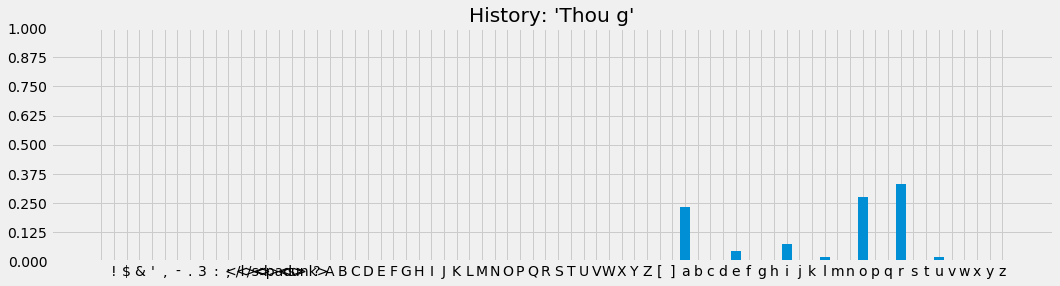

In [13]:
targets, probs = charlm.get_next_probability(char_encoder, [prompt.split() + [' ' if prompt.endswith(' ') else '']])
utils.plot_output(targets, probs[0], prompt)
sampled = targets[torch.multinomial(torch.tensor(probs), 1).item()]
prompt += sampled
print("Sampled symbol: '{}'".format(sampled))

## Sampling with Temperature

In [4]:
# some imports for interactive viz
from ipywidgets import interact, ToggleButton

# lm = UnsmoothedLM(5).fit(characters_from_files('shakespeare_input.txt'))

# auxiliary functions to query the ngram model
def query_lm(model=lm, seed='irst'):
    """Query a random probability from the NGRAM lm model"""
    targets, probs = zip(*model.model[tuple(seed)])
    probs = np.array(probs)
    return targets, probs, seed

# auxiliary function to query the rnn model
def query_rnnlm(model, encoder, seed='Hi there'):
    targets, probs = model.get_next_probability(encoder, [seed.split()])
    probs = probs[0] # drop batch dim
    return targets, probs, seed

In [14]:
targets, probs, prefix = query_rnnlm(charlm, char_encoder, seed="To be or not to b") # from not to be...

def plot(temperature=1.0, top_k=0, top_p=0.0):
    # sort alphabetically
    xticks, y = zip(*sorted(zip(targets, probs), key=lambda t: t[0]))
    x = np.arange(len(targets))
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    y = utils.apply_temperature(np.array(y), temperature)
    
    if top_k:
        y = utils.apply_tok_k_sampling(y, top_k)
    elif top_p:
        y = utils.apply_nucleus_sampling(y, top_p)
    
    ax.bar(x, y)
    ax.set_title(''.join(prefix))
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.linspace(0, 1, 9))
    return ax

interact(plot, temperature=(1e-2, 5), top_k=(0, len(probs)), top_p=(0.0, 1.0))

interactive(children=(FloatSlider(value=1.0, description='temperature', max=5.0, min=0.01), IntSlider(value=0,…

<function __main__.plot(temperature=1.0, top_k=0, top_p=0.0)>

## Effect of temperature on the output

In [150]:
def sample_lines(model, encoder, nlines=5, **kwargs):
    hidden = None
    for _ in range(nlines):
        (sample, _), score, hidden, _ = model.sample(encoder, hidden=hidden, **kwargs, avoid_unk=True)
        print(sample[0])

In [156]:
for i in range(1, 11):
    tau = i / 10
    print("Tau={}\n==============".format(tau))
    sample_lines(wordlm, word_encoder, tau=tau)
    print()
    print()

Tau=0.1
I ' ll not be gone : I ' ll be sworn to be a man , And I will not be satisfied .
I have a father , and a man , a cat , A very pretty one , and a poor man , A very scurvy and most sweet friend , A very valiant gentleman , and a good man .
' Tis not a fault , and I am sure I am not well .
I have a thousand pound of you , and I am a man , and a good man , and a good carriage , and a good carriage , and a good man .
a good man , sir , that I am a gentleman , and a good man , and a good man , and a good friend , and a good friend , and a good friend .


Tau=0.2
I am a gentleman , and I am sure I have been a woman , and I am a man : I ' ll be sworn , if I be not a man .
' Tis true : I ' ll give you all .
I ' ll tell you , sir , I will not be a man , And I am sure I am not well .
' Tis not so , ' tis not so .
I ' ll have a bout , and I will be a fool .


Tau=0.3
I am not mad , my lord , and I am sorry To be a king , and I am not a man .
' Tis not so well as I have done , And yet I ' l